In [1]:
import pytensor
pytensor.config.cxx = ""

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from physiokinematic.simulate import simulate
# Generate synthetic dataset
data = simulate(10, seed=4634)

In [3]:
data

,glong,glat,vlsr,e_vlsr,radius,true_te,te,e_te,line,e_line,...,line_freq,telescope,beam_area,Rgal,distance,log10_n,log10_q,log10_Rs,log10_em,kdar
0,348.664409,-0.142474,16.891723,1.0,48.946016,7591.432223,NaN,100.0,2.283521,0.1,...,8000.0,simulated,9178.029287,14.683380,22.602163,1.288959,48.332244,0.729442,3.608391,
1,18.441407,1.984871,116.639899,1.0,78.720155,5159.579079,5159.579079,100.0,31.293635,0.1,...,8000.0,simulated,9178.029287,2.609841,7.379059,1.637139,48.189262,0.449661,4.024969,
2,303.295367,-0.003645,81.079697,1.0,78.418873,7457.989917,NaN,100.0,9.531155,0.1,...,8000.0,simulated,9178.029287,13.624735,16.274506,1.353421,48.647351,0.791503,3.799375,
3,299.199744,-0.358975,22.208698,1.0,84.686562,6444.691546,6444.691546,100.0,7.547438,0.1,...,8000.0,simulated,9178.029287,9.256122,9.888527,1.301463,47.994487,0.608521,3.512476,
4,65.037227,0.176925,-97.653513,1.0,207.799950,7538.345392,7538.345392,100.0,47.264472,0.1,...,8000.0,simulated,9178.029287,14.593529,16.022713,1.437084,50.064036,1.207956,4.383154,
5,8.681120,0.639975,65.026527,1.0,151.419844,4496.058312,NaN,100.0,75.858147,0.1,...,8000.0,simulated,9178.029287,2.149083,9.833576,1.516276,49.173958,0.858469,4.192051,
6,12.224696,0.173377,36.498564,1.0,166.016777,5470.089600,5470.089600,100.0,32.787397,0.1,...,8000.0,simulated,9178.029287,4.522410,12.159686,1.344229,49.226405,0.990649,3.980137,
7,354.472711,-0.560091,-8.933537,1.0,25.080540,6119.676980,6119.676980,100.0,0.756165,0.1,...,8000.0,simulated,9178.029287,5.702026,13.776206,1.497688,47.233499,0.224041,3.520447,
8,39.949701,1.261277,76.963909,1.0,225.040268,5970.596000,NaN,100.0,25.759713,0.1,...,8000.0,simulated,9178.029287,5.459299,7.781728,1.354283,49.061298,0.928911,3.938506,
9,56.045256,-0.289396,-93.157283,1.0,50.285602,7940.694305,NaN,100.0,5.383415,0.1,...,8000.0,simulated,9178.029287,15.218917,18.189707,1.518107,48.542745,0.646844,3.984087,


In [4]:
from physiokinematic import NEWmodel
import importlib
importlib.reload(NEWmodel)

<module 'physiokinematic.NEWmodel' from '/Users/ryanbakko/Desktop/Trey Research/physiokinematic/physiokinematic/NEWmodel.py'>

In [5]:
from physiokinematic.NEWmodel import model as pkmodel
# setup model
model = pkmodel(data)

/Users/ryanbakko/miniconda3/envs/physiokinematic/lib/python3.12/site-packages/pymc/model/core.py:1278: ImputationWarning: Data in te contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


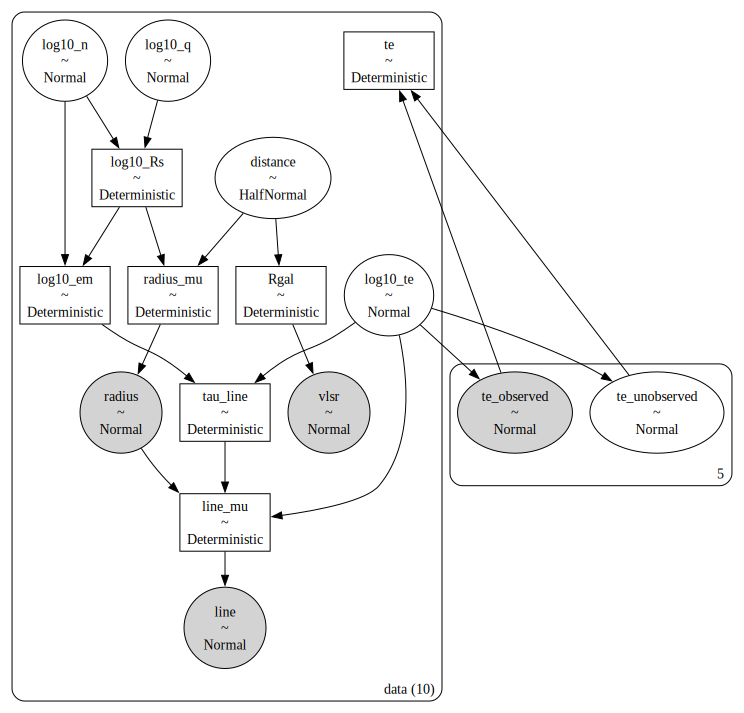

In [6]:
# visualize model
model.to_graphviz()

In [7]:
import pymc as pm

# sample prior predictive
with model:
    prior = pm.sample_prior_predictive(1000)

Sampling: [distance, line, log10_n, log10_q, log10_te, radius, te_observed, te_unobserved, vlsr]


(360.0, 0.0)

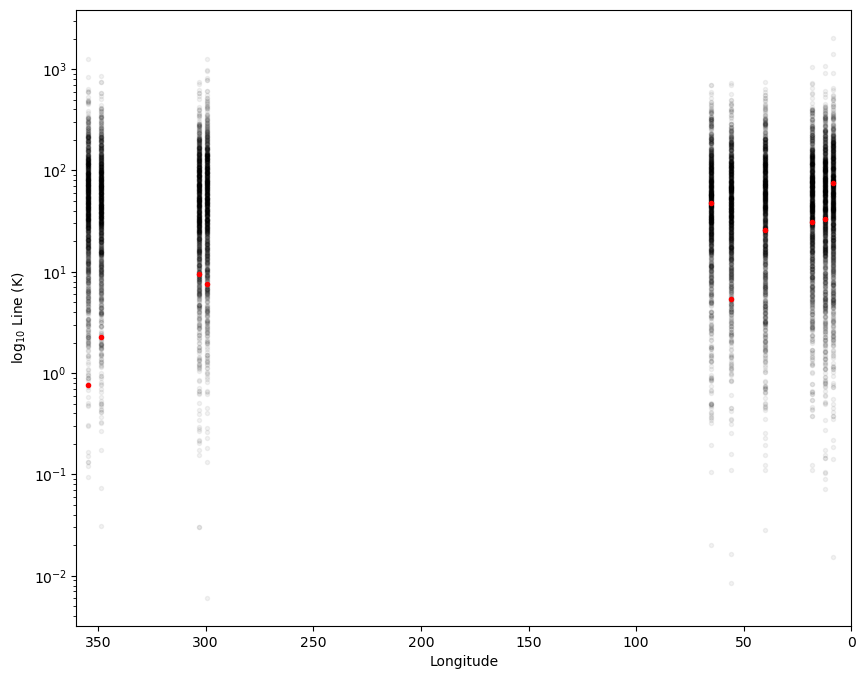

In [8]:
import matplotlib.pyplot as plt

# plot prior predictive samples
fig, ax = plt.subplots(figsize=(10, 8))
for draw in prior.prior_predictive.draw:
    ax.plot(
        data["glong"],
        prior.prior_predictive["line"].sel(chain=0, draw=draw),
        "k.",
        alpha=0.05,
    )
ax.plot(data["glong"], data["line"], "r.")
ax.set_xlabel("Longitude")
ax.set_ylabel("log$_{10}$ Line (K)")
ax.set_yscale("log")
ax.set_xlim(360.0, 0.0)

(360.0, 0.0)

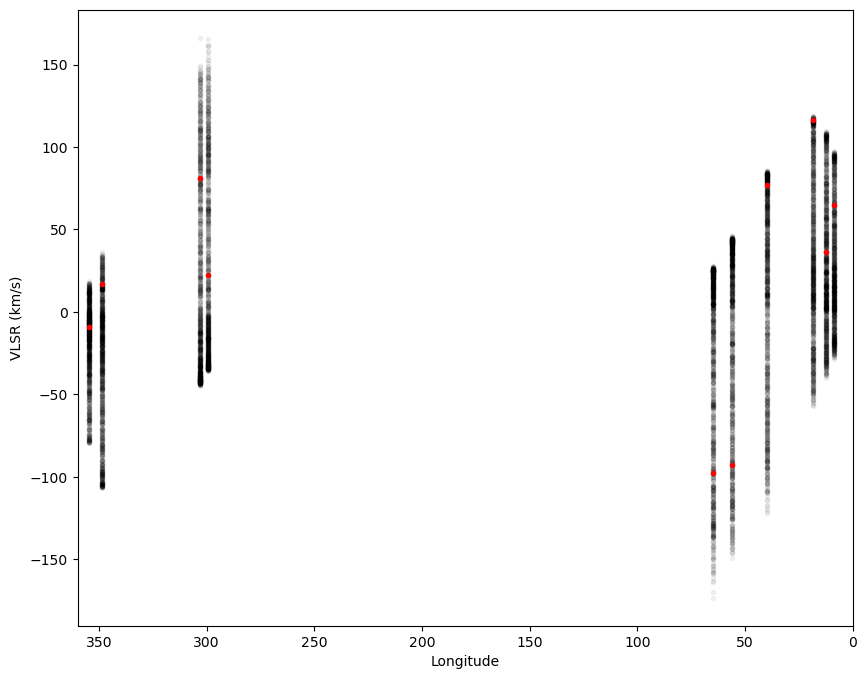

In [9]:
#Glong vs VLSR: need better priors
fig, ax = plt.subplots(figsize=(10, 8))
for draw in prior.prior_predictive.draw:
    ax.plot(
        data["glong"],
        prior.prior_predictive["vlsr"].sel(chain=0, draw=draw),
        "k.",
        alpha=0.05,
    )
ax.plot(data["glong"], data["vlsr"], "r.")
ax.set_xlabel("Longitude")
ax.set_ylabel("VLSR (km/s)")
ax.set_xlim(360.0, 0.0)


(360.0, 0.0)

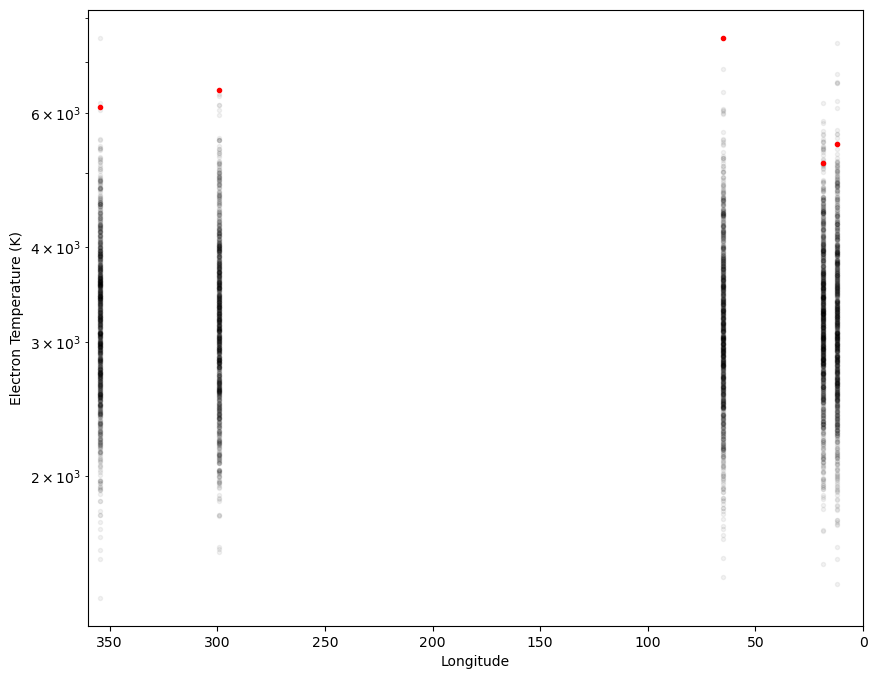

In [10]:
#Need better electron temp priors so model converges faster
fig, ax = plt.subplots(figsize=(10, 8))
for draw in prior.prior_predictive.draw:
    ax.plot(
        data.loc[~data["te"].isna(), "glong"],
        prior.prior_predictive["te_observed"].sel(chain=0, draw=draw),
        "k.",
        alpha=0.05,
    )
ax.plot(data["glong"], data["te"], "r.")
ax.set_yscale('log')
ax.set_xlabel("Longitude")
ax.set_ylabel("Electron Temperature (K)")
ax.set_xlim(360.0, 0.0)

In [11]:

from physiokinematic.simulate import simulate
hii_data = simulate(1000)  # Step 1: Simulate HII regions

In [12]:
hii_data

,glong,glat,vlsr,e_vlsr,radius,true_te,te,e_te,line,e_line,...,line_freq,telescope,beam_area,Rgal,distance,log10_n,log10_q,log10_Rs,log10_em,kdar
0,196.880302,-1.265708,34.938789,1.0,50.358890,8643.992363,8643.992363,100.0,6.205795,0.1,...,8000.0,simulated,9178.029287,16.056790,8.068556,1.761276,47.971891,0.294446,4.118028,
1,15.478401,0.162145,43.683669,1.0,92.755562,5441.602048,5441.602048,100.0,18.918105,0.1,...,8000.0,simulated,9178.029287,4.695894,12.029451,1.348982,48.463444,0.733160,3.732154,
2,345.592360,0.475399,-79.657642,1.0,169.423907,4325.342307,NaN,100.0,62.107755,0.1,...,8000.0,simulated,9178.029287,3.034269,5.655855,1.554029,48.675200,0.667047,4.076135,
3,37.511379,0.062208,36.667823,1.0,120.958300,6001.782030,NaN,100.0,59.961474,0.1,...,8000.0,simulated,9178.029287,6.661902,10.911034,1.600878,49.185984,0.806076,4.308862,
4,32.696571,0.325194,0.950869,1.0,69.674392,7105.046839,NaN,100.0,9.852088,0.1,...,8000.0,simulated,9178.029287,8.226051,13.815556,1.453071,48.479189,0.669016,3.876187,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,334.920030,-0.526374,-41.669465,1.0,111.648661,4979.530926,4979.530926,100.0,34.625042,0.1,...,8000.0,simulated,9178.029287,5.826577,12.083548,1.405090,48.823048,0.815622,3.926833,
996,8.007093,-0.683600,15.995955,1.0,213.438498,5202.449344,NaN,100.0,22.980687,0.1,...,8000.0,simulated,9178.029287,5.295043,13.258754,1.174021,49.326091,1.137350,3.786421,
997,21.552789,-0.353030,115.326958,1.0,124.846023,4776.517772,4776.517772,100.0,49.841447,0.1,...,8000.0,simulated,9178.029287,3.010117,7.843606,1.539444,48.674283,0.676465,4.056383,
998,348.678912,-0.670786,-87.928605,1.0,182.303611,4397.241896,NaN,100.0,31.425082,0.1,...,8000.0,simulated,9178.029287,2.074435,6.690932,1.360072,48.601712,0.771856,3.793030,


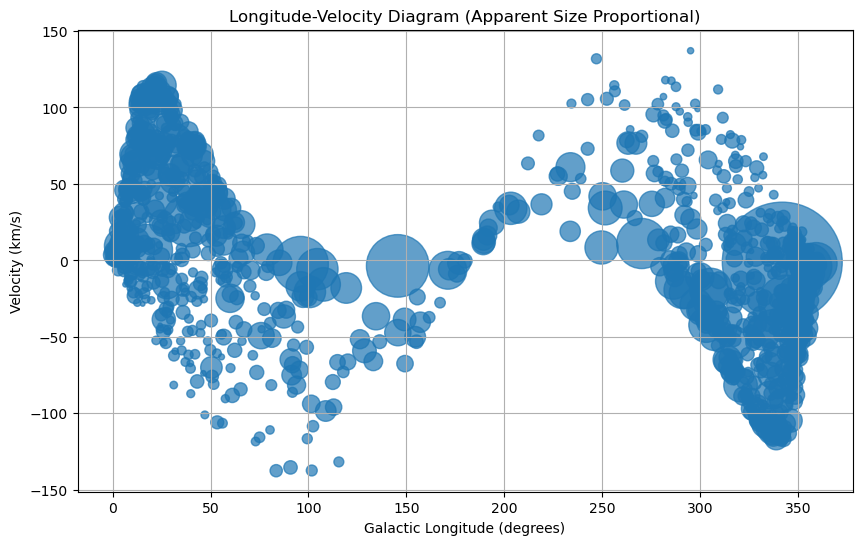

In [13]:
from physiokinematic import plot
plot.plot_longitude_velocity_diagram(hii_data)

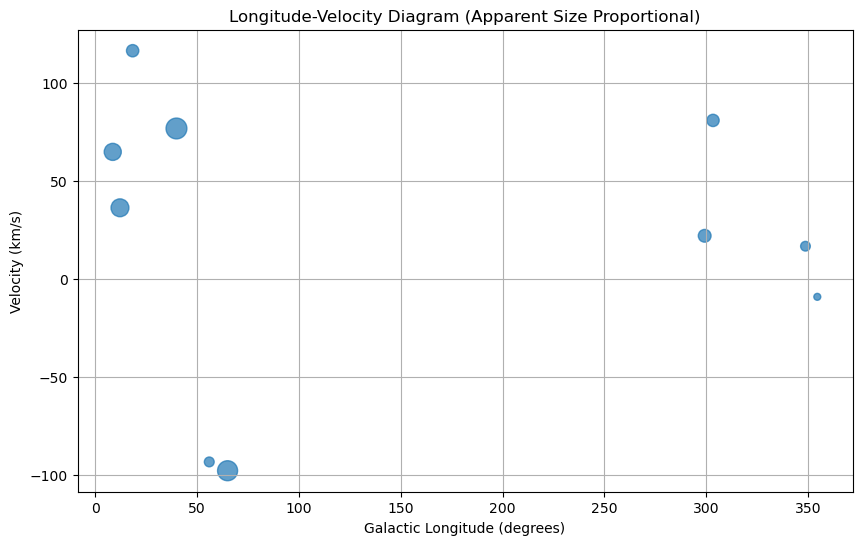

In [14]:
from physiokinematic import plot
plot.plot_longitude_velocity_diagram(data)

In [15]:
import importlib
importlib.reload(plot)

<module 'physiokinematic.plot' from '/Users/ryanbakko/Desktop/Trey Research/physiokinematic/physiokinematic/plot.py'>

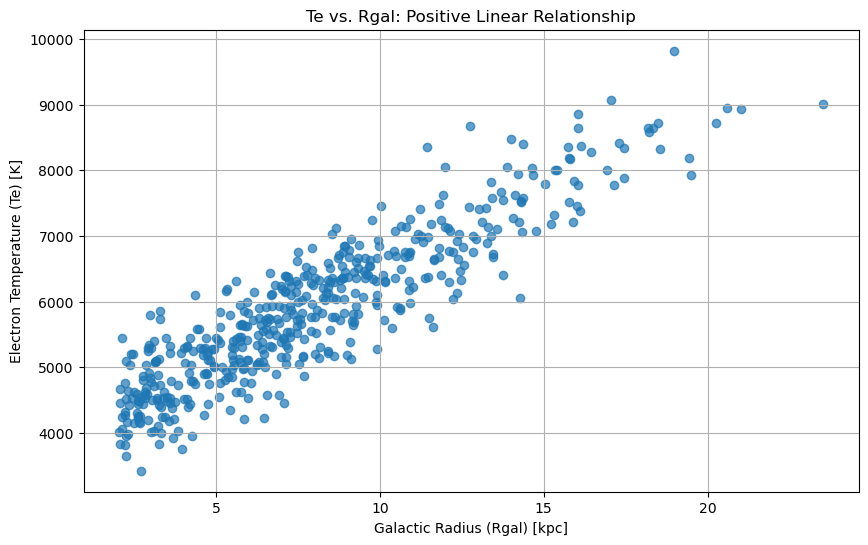

In [16]:
plot.plot_te_vs_rgal(hii_data)

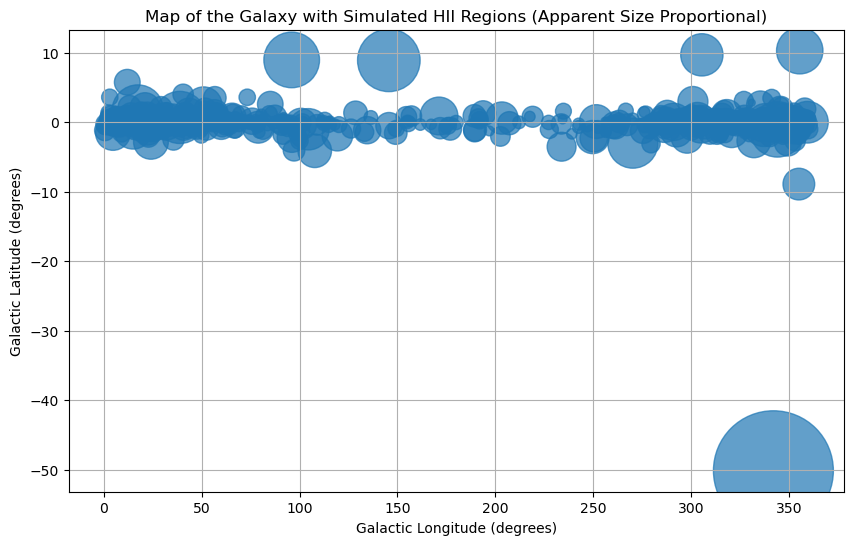

In [17]:
plot.plot_galaxy_map(hii_data)

In [18]:
# sample posterior- dont run on macbook. run on scylla 
with model:
    trace = pm.sample(chains=8, cores=8, tune=1000, draws=1000, target_accept=0.85)

/Users/ryanbakko/miniconda3/envs/physiokinematic/lib/python3.12/site-packages/pytensor/tensor/rewriting/elemwise.py:1027: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/ryanbakko/miniconda3/envs/physiokinematic/lib/python3.12/site-packages/pytensor/tensor/rewriting/elemwise.py:1027: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
/Users/ryanbakko/miniconda3/envs/physiokinematic/lib/python3.12/site-packages/pytensor/tensor/rewriting/elemwise.py:1027: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
/Users/ryanbakko/miniconda3/envs/physiokinematic/lib/python3.12/site-packages/pytensor/tensor/rewriting/elemwise.py:1027: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
/Users/r


You can find the C code in this temporary file: /var/folders/37/fz3nr39j6wz1yt2vpr9w4ctm0000gn/T/pytensor_compilation_error_jf6bcik7


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.



You can find the C code in this temporary file: /var/folders/37/fz3nr39j6wz1yt2vpr9w4ctm0000gn/T/pytensor_compilation_error_prfp_39y


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.



You can find the C code in this temporary file: /var/folders/37/fz3nr39j6wz1yt2vpr9w4ctm0000gn/T/pytensor_compilation_error_jwx0pg4j


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.



You can find the C code in this temporary file: /var/folders/37/fz3nr39j6wz1yt2vpr9w4ctm0000gn/T/pytensor_compilation_error_wljlf98g


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.



You can find the C code in this temporary file: /var/folders/37/fz3nr39j6wz1yt2vpr9w4ctm0000gn/T/pytensor_compilation_error_7njlgznw


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Process worker_chain_4:
Process worker_chain_3:
Process worker_chain_1:
Process worker_chain_0:
Traceback (most recent call last):
  File "/Users/ryanbakko/miniconda3/envs/physiokinematic/lib/python3.12/site-packages/pytensor/link/vm.py", line 1227, in make_all
    node.op.make_thunk(node, storage_map, compute_map, [], impl=impl)
  File "/Users/ryanbakko/miniconda3/envs/physiokinematic/lib/python3.12/site-packages/pytensor/link/c/op.py", line 119, in make_thunk
    return self.make_c_thunk(node, storage_map, compute_map, no_recycling)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ryanbakko/miniconda3/envs/physiokinematic/lib/python3.12/site-packages/pytensor/link/c/op.py", line 84, in make_c_thunk
    outputs = cl.make_thunk(
              ^^^^^^^^^^^^^^
  File "/Users/ryanbakko/miniconda3/envs/physiokinematic/lib/python3.12/site-packages/pytensor/link/

KeyboardInterrupt: 


You can find the C code in this temporary file: /var/folders/37/fz3nr39j6wz1yt2vpr9w4ctm0000gn/T/pytensor_compilation_error_yhgusbhs


Process worker_chain_5:
Traceback (most recent call last):
  File "/Users/ryanbakko/miniconda3/envs/physiokinematic/lib/python3.12/site-packages/pytensor/link/vm.py", line 1227, in make_all
    node.op.make_thunk(node, storage_map, compute_map, [], impl=impl)
  File "/Users/ryanbakko/miniconda3/envs/physiokinematic/lib/python3.12/site-packages/pytensor/link/c/op.py", line 119, in make_thunk
    return self.make_c_thunk(node, storage_map, compute_map, no_recycling)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ryanbakko/miniconda3/envs/physiokinematic/lib/python3.12/site-packages/pytensor/link/c/op.py", line 84, in make_c_thunk
    outputs = cl.make_thunk(
              ^^^^^^^^^^^^^^
  File "/Users/ryanbakko/miniconda3/envs/physiokinematic/lib/python3.12/site-packages/pytensor/link/c/basic.py", line 1182, in make_thunk
    cthunk, module, in_storage, out_storage, error_storage = self.__compile__(
                                              

In [ ]:
 pm.summary(trace)

In [ ]:
# sample posterior predictive
with model:
    posterior = pm.sample_posterior_predictive(trace.sel(draw=slice(None, None, 10)))

In [ ]:
#testing distance(glong,Radius)
import numpy as np
import matplotlib.pyplot as plt
glong = np.linspace(0, 2*np.pi, 1000)
R_0 = 10
R = 15
d = R_0 * np.cos(glong) + np.sqrt(R_0**2 * np.sin(glong)**2 + R**2)

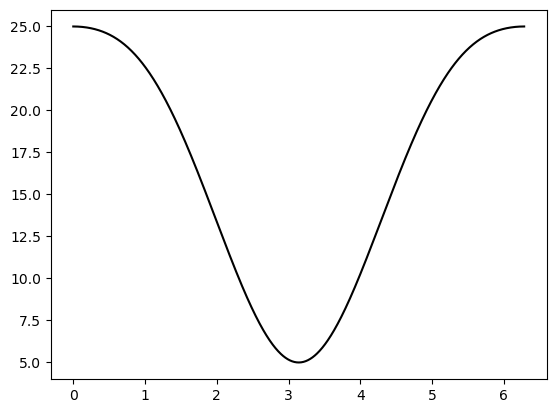

In [ ]:
plt.plot(glong, d, "k-")

